In [1]:
import gym
import numpy as np
import time
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [2]:
# The environment
env = gym.make('Taxi-v3')

# Class for the general TDAgent

In [3]:
class TDAgent():
    '''
    General class for agents which can be trained using tabular TD methods (Q-learning, SARSA, Expected SARSA and Double-Q Learning)
    '''

    def __init__(self, env, gamma=0.9, alpha=0.1, epsilon=0.1):
        self.env = env
        
        # Agent parameters
        self.gamma = gamma
        self.alpha = alpha

        # The base value of epsilon. TDAgent.epsilon is decayed with iterations while training
        self.epsilon_base = epsilon
        self.epsilon = epsilon

        # State and action sets
        self.states = [s for s in range(self.env.nS)]
        self.actions = [a for a in range(self.env.nA)]

        # State-action value table
        self.Q = np.array([np.array([0.0 for action in self.actions]) for state in self.states])

        # Extra table for use in Double-Q learning
        self.Q_ = np.array([np.array([0.0 for action in self.actions]) for state in self.states])

    def reset(self):
        self.epsilon = self.epsilon_base
        self.Q = np.array([np.array([0.0 for action in self.actions]) for state in self.states])

    # Returns the action for 'state' giving highest return based on action value table 'Q'
    def greedy_action(self, state, Q=None):
        Q = self.Q if Q is None else Q
        max_action_value = np.max(Q[state])
        optimal_actions = [action for action in self.actions if Q[state][action] == max_action_value]
        return np.random.choice(optimal_actions)

    # Returns a greedy action with probability 1 - self.epsilon. 
    def epsilon_greedy_action(self, state, Q=None):
        Q = self.Q if Q is None else Q
        if np.random.random() > self.epsilon:
            return self.greedy_action(state, Q)
        else:
            return np.random.choice(self.actions)

    # Returns the expected value of a state if an epsilon greedy policy based on self.Q is followed
    # Used in Expected SARSA
    def expected_state_value(self, state):
        state_policy = np.array([self.epsilon/self.env.nA for action in self.actions])
        state_policy[self.greedy_action(state)] += 1 - self.epsilon
        return np.dot(self.Q[state], state_policy)

    # Simulate an episode using an epsilon greedy policy based on self.Q
    def run(self, render=False, pause_time=0.5):
        curr_state = self.env.reset()
        if render:
            self.env.render()
        done = False
        ret = 0
        while not done:
            action = self.epsilon_greedy_action(curr_state)
            next_state, reward, done, info = self.env.step(action)
            ret = self.gamma * ret + reward
            curr_state = next_state
            if render:
                clear_output()
                self.env.render()
                time.sleep(pause_time)
        return ret

    # Make a Q-Learning update over a single episode. 
    # Returns the discounted return obtained during the episode.
    def update_q_learning(self):
        curr_state = self.env.reset()
        done = False
        ret = 0
        while not done:
            action = self.epsilon_greedy_action(curr_state)
            next_state, reward, done, info = self.env.step(action)
            ret = self.gamma * ret + reward
            self.Q[curr_state][action] = self.Q[curr_state][action] + \
                                         self.alpha * (reward + self.gamma*self.Q[next_state][self.greedy_action(next_state)] - self.Q[curr_state][action])
            curr_state = next_state
        return ret

    # Make a Sarsa update over a single episode. 
    # Returns the discounted return obtained during the episode.
    def update_sarsa(self):
        curr_state = self.env.reset()
        curr_action = self.epsilon_greedy_action(curr_state)
        done = False
        ret = 0
        while not done:
            next_state, reward, done, info = self.env.step(curr_action)
            ret = self.gamma * ret + reward
            next_action = self.epsilon_greedy_action(next_state)
            self.Q[curr_state][curr_action] = self.Q[curr_state][curr_action] + \
                                              self.alpha * (reward + self.gamma*self.Q[next_state][next_action] - self.Q[curr_state][curr_action])
            curr_state = next_state
            curr_action = next_action
        return ret

    # Make an expected Sarsa update over a single episode. 
    # Returns the discounted return obtained during the episode.
    def update_expected_sarsa(self):
        curr_state = self.env.reset()
        done = False
        ret = 0
        while not done:
            action = self.epsilon_greedy_action(curr_state)
            next_state, reward, done, info = self.env.step(action)
            ret = self.gamma * ret + reward
            self.Q[curr_state][action] = self.Q[curr_state][action] + \
                                         self.alpha * (reward + self.gamma*self.expected_state_value(next_state) - self.Q[curr_state][action])
            curr_state = next_state
        return ret

    # Make a Double-Q learning update over a single episode. 
    # Returns the discounted return obtained during the episode.
    def update_double_q(self):
        curr_state = env.reset()
        done = False
        ret = 0
        while not done:
            action = self.epsilon_greedy_action(curr_state, Q=(self.Q + self.Q_))
            next_state, reward, done, info = self.env.step(action)
            ret = self.gamma * ret + reward
            if np.random.random() > 0.5:
                self.Q[curr_state][action] = self.Q[curr_state][action] + \
                                             self.alpha * (reward + self.gamma*self.Q_[next_state][self.greedy_action(next_state, Q=self.Q)] - self.Q[curr_state][action])
            else:
                self.Q_[curr_state][action] = self.Q_[curr_state][action] + \
                                              self.alpha * (reward + self.gamma*self.Q[next_state][self.greedy_action(next_state, Q=self.Q_)] - self.Q_[curr_state][action])
            curr_state = next_state
        return ret

    # General function to train the agent
    # Returns a list of discounted returns obtained at each iteration of training
    # method : {"Q"/"SARSA"/"EXPECTED_SARSA/"DOUBLE_Q"}
    def train(self, method, num_iters=1000, printIntermediateReturns=False, num_runs=10):
        update_func = {
            "Q" : self.update_q_learning, 
            "SARSA": self.update_sarsa, 
            "EXPECTED_SARSA": self.update_expected_sarsa,
            "DOUBLE_Q": self.update_double_q
        }
        self.reset()
        rets = []
        for iteration in range(1, num_iters+1):
            update_func[method]()
            ret = np.mean([self.run() for _ in range(num_runs)])
            rets.append(ret)
            if iteration % 100 == 0 and printIntermediateReturns:
                print(f"Iteration {iteration} return: {ret}")
            self.epsilon = self.epsilon_base / iteration
        return rets

## Plotting Utils

In [4]:
def plot_training_returns(rets, title="Returns vs. Episodes", N=10):
    X = [i+1 for i in range(len(rets))]
    plt.plot(X, rets)
    plt.title(title)
    plt.xlabel("Episodes")
    plt.ylabel(f" Average returns over N={N} rounds")
    plt.show()

# Q Learning

In [5]:
# Create and train an agent
q_learning_agent = TDAgent(env)
returns = q_learning_agent.train(method="Q", num_iters=10000)

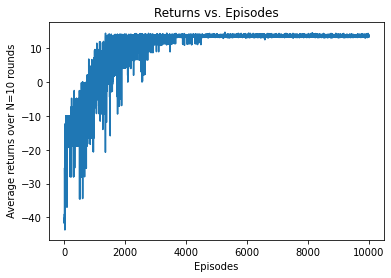

In [6]:
# Plot the returns
plot_training_returns(returns)

# SARSA

In [7]:
# Create and train an agent
sarsa_agent = TDAgent(env)
returns = sarsa_agent.train(method="SARSA", num_iters=10000)

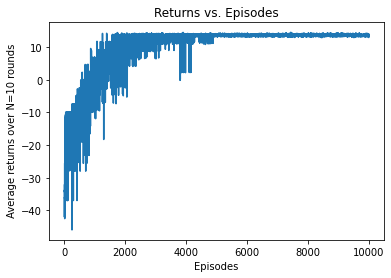

In [8]:
# Plot the returns
plot_training_returns(returns)

# Expected SARSA

In [9]:
# Create and train an agent
expected_sarsa_agent = TDAgent(env)
returns = expected_sarsa_agent.train(method="EXPECTED_SARSA", num_iters=10000)

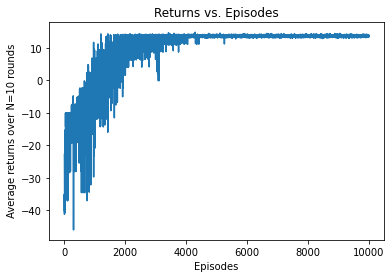

In [10]:
# Plot the returns
plot_training_returns(returns)

# Double Q-Learning

In [11]:
# Create and train an agent
double_q_agent = TDAgent(env)
returns = double_q_agent.train(method="DOUBLE_Q", num_iters=10000)

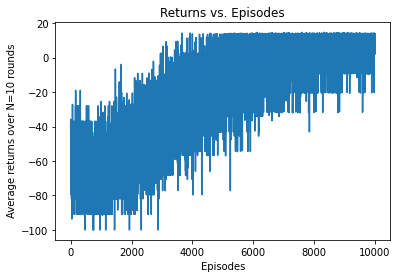

In [12]:
# Plot the returns
plot_training_returns(returns)